In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents = True, exist_ok = True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))
housing = load_housing_data()


In [ ]:
#show me 5 head raw in data
'''housing.head()
housing.info()
housing["ocean_proximity"].value_counts()'''
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

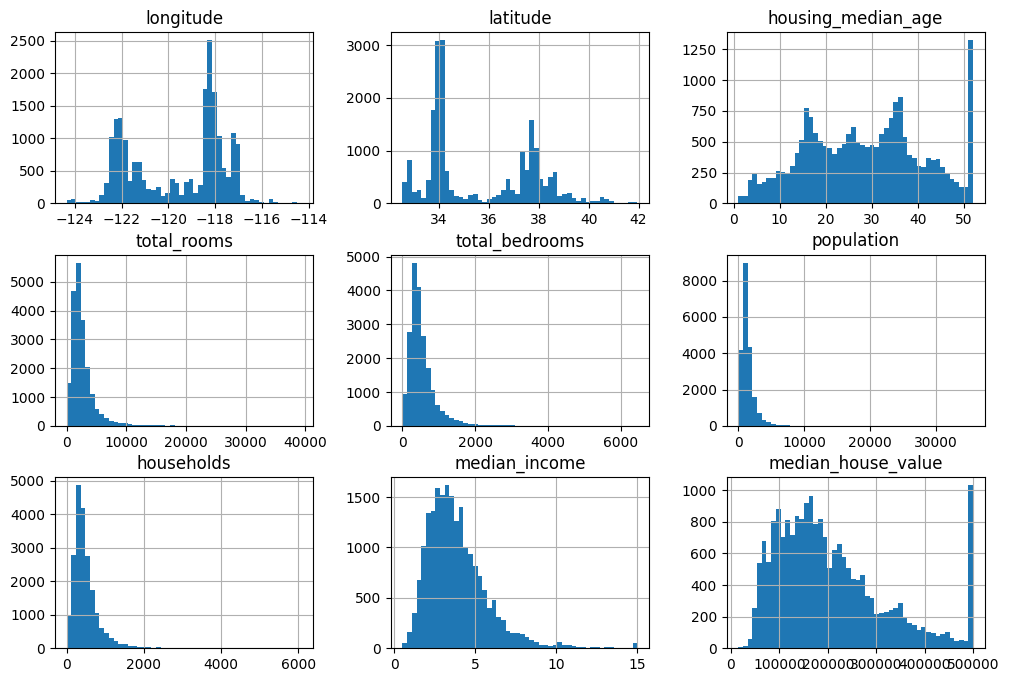

In [ ]:
## Make Histogram
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12,8))

In [ ]:
## Make Test Set
import numpy as np

def ShuffleSplitData(data, testRatio):
    shuffledIndices = np.random.permutation(len(data))
    testSetSize = int(len(data) * testRatio)
    testIndices = shuffledIndices[:testSetSize]
    trainIndices = shuffledIndices[testSetSize:]
    return data.iloc[trainIndices], data.iloc[testIndices]

In [ ]:
trainSet, testSet = ShuffleSplitData(housing, 0.2)
len(trainSet)
## len(testSet)

16512

In [ ]:
from zlib import crc32

## Test Set does not contain previous train set
def IDinTestSet(identifier, testRatio):
    return crc32(np.int64(identifier)) < testRatio * 2**32

def SplitDataWithIdHash(data, testRatio, idColumn):
    ids = data[idColumn]
    inTestSet = ids.apply(lambda id_:IDinTestSet(id_, testRatio))
    return data.loc[~inTestSet], data.loc[inTestSet]

In [ ]:
## Add index
housingWithID = housing.reset_index()

train_set, test_set = SplitDataWithIdHash(housingWithID, 0.2, "index")

In [ ]:
## Make 5 income categories to block data bias
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

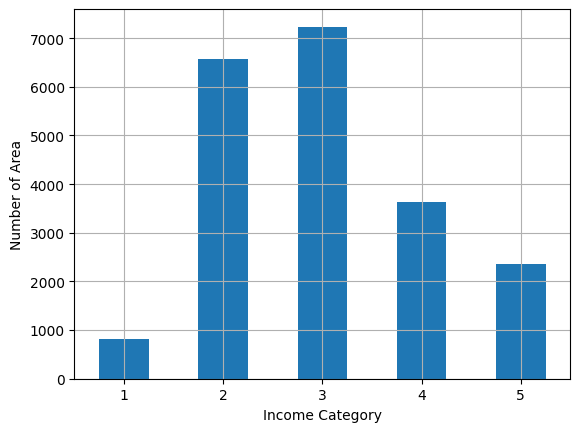

In [ ]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid = True)
plt.xlabel("Income Category")
plt.ylabel("Number of Area")
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

## Make 10 income categories to block data bias
splitter = StratifiedShuffleSplit(n_splits = 10, test_size= 0.2, random_state = 42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
## Use first split
strat_train_set, strat_test_set = strat_splits[0]

In [ ]:
## income category proportions
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
## remove the income_cat attribute so the data is back to its original state
'''for set_ in(strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)'''

'for set_ in(strat_train_set, strat_test_set):\n    set_.drop("income_cat", axis = 1, inplace = True)'

In [ ]:
## Let’s create a copy  so you can play with it without harming the training set:
housing = strat_train_set.copy()

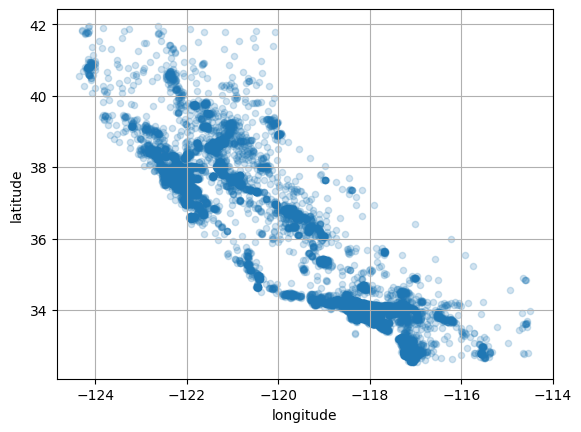

In [ ]:
## Create a scatterplot of all districts to visualize the data
housing.plot(kind="scatter", x = "longitude", y = "latitude", grid = True, alpha = 0.2) ##alpha -> high density of data point
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

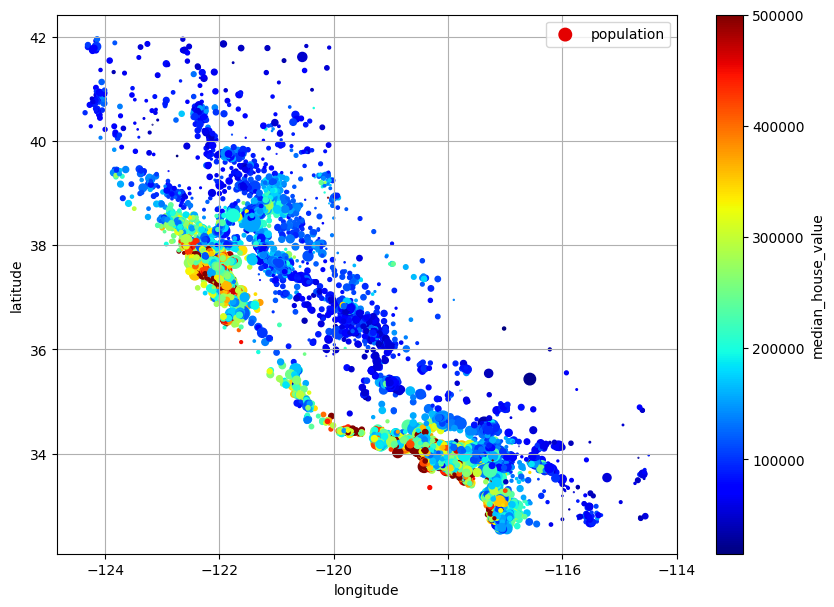

'cax = plt.gcf().get_axes()[1]\n             cax.set_ylabel("Median House Value")\n             plt.xlabel("longitude")\n             plt.ylabel("latitude")'

In [ ]:
## Let’s look at the housing prices
housing.plot(kind="scatter", x = "longitude", y = "latitude", grid = True,
             s = housing["population"] / 100, label = "population",
             c = "median_house_value", cmap = "jet", colorbar = True,
             legend = True, sharex = False, figsize = (10, 7))

plt.show()
'''cax = plt.gcf().get_axes()[1]
             cax.set_ylabel("Median House Value")
             plt.xlabel("longitude")
             plt.ylabel("latitude")'''

In [ ]:
## Standard correlation coefficient
corr_matrix = housing.corr(numeric_only = True)
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

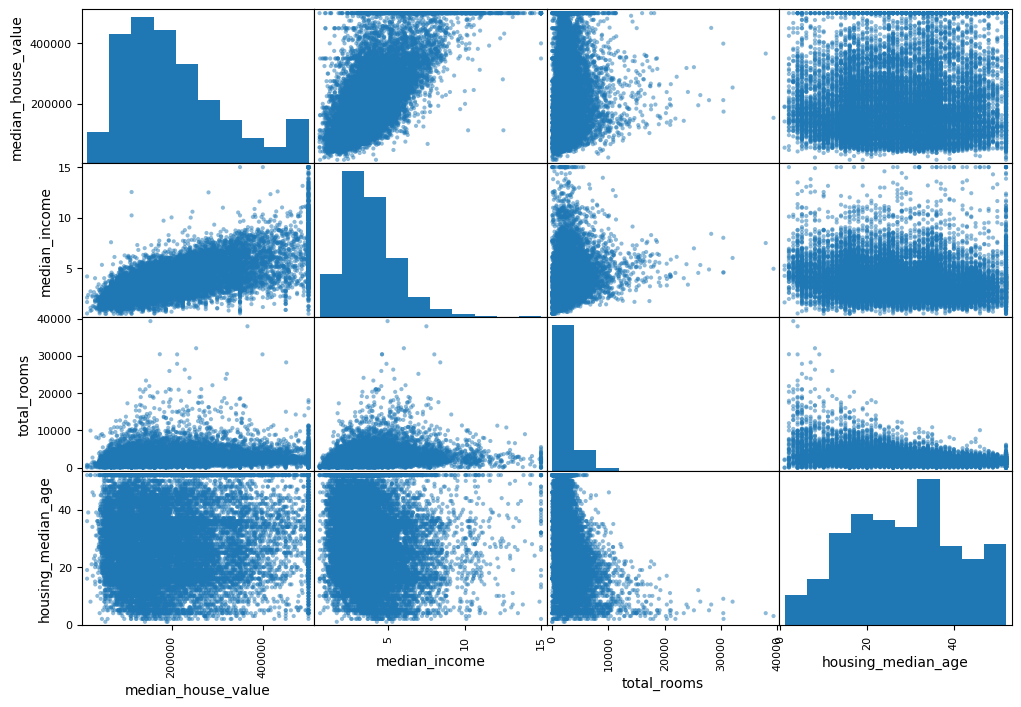

In [ ]:
## scatter_matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

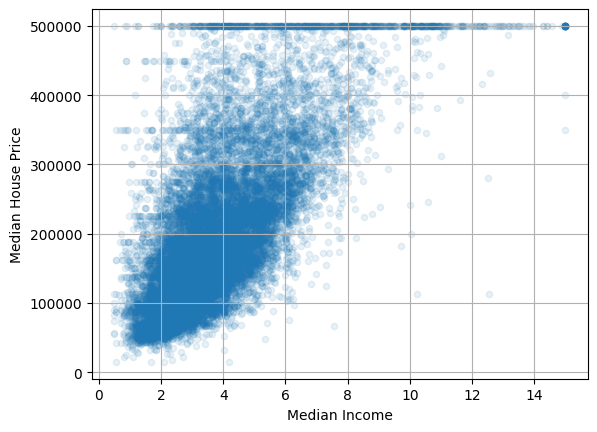

In [ ]:
housing.plot(kind="scatter", x = "median_income", y = "median_house_value",
             alpha = 0.1, grid = True)
plt.xlabel("Median Income")
plt.ylabel("Median House Price")
plt.show()

In [ ]:
## Try out various attribute combinations
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_house"] = housing["population"] / housing["households"]

In [ ]:
## Separate the predictors and the labels
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
"""median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace = True)"""
##s create a few functions to take care of  missing features
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
## Convert these categories from text to numbers
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
## One-Hot-Encoding
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
## Output is a SciPy sparse matrix
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
df_test = pd.DataFrame({"ocean_proximity" : ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [ ]:
cat_encoder.transform(df_test)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [ ]:
df_test_unknown = pd.DataFrame({"ocean_proximity" : ["1H OCEAN", "INLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_1H OCEAN,ocean_proximity_INLAND
0,1,0
1,0,1


In [ ]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [ ]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [ ]:
'''df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns = cat_encoder.get_feature_names_out(),
                         index = df_test_unknown.index)'''


'df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),\n                         columns = cat_encoder.get_feature_names_out(),\n                         index = df_test_unknown.index)'

In [ ]:
## min-max scaling or normalization
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range = (-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [ ]:
## Standardization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)

In [ ]:
## Scaling, Train Linear Regeressin Model, Prediction
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] ## Suppose that this is new data
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer = StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [ ]:
## Log Transformer
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [ ]:
## Gauss RBF similarity
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args = dict(Y = [[35.]], gamma = 0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [ ]:
## Geographical Simularity beetween each area and San Francisco
sf_coords = 37.7749, 122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args = dict(Y=[sf_coords], gamma = 0.1))
sf_smill = sf_transformer.transform(housing[["latitude", "longitude"]])

In [ ]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [ ]:
## User defined Transformer Operate as StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True):
        self.with_mean = with_mean

    def fit(self, X, y = None):
        X = check_array(X)
        self.mean_ = X.mean(axis = 0)
        self.scale_ = X.std(axis = 0)
        self.n_features_in = X.shape[1]
        return self

    def transforn(self, X):
      check_is_fitted(self)
      X = check_array(X)
      assert self.n_features_in_ == X.shape[1]
      if self.with_mean:
          X = X - self.mean_
      return X / self.scale

In [ ]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [ ]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

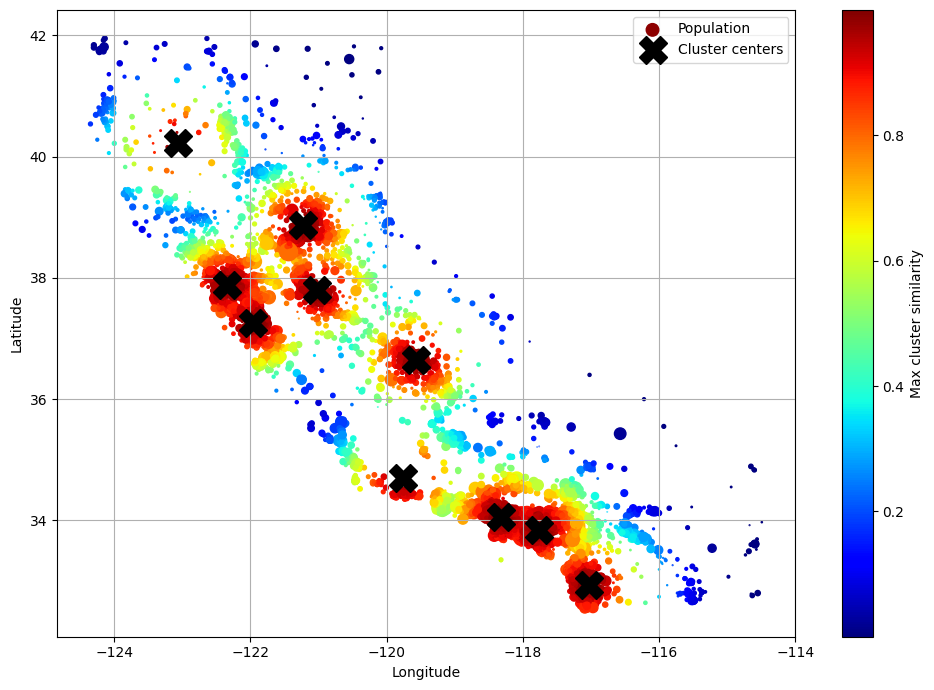

In [ ]:
# extra code – this cell generates Figure 2–19

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy = "median"), StandardScaler())

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [ ]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns = num_pipeline.get_feature_names_out(),
    index = housing_num.index)


In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude",	"latitude","housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder(handle_unknown = "ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include = object)),
)

housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # uses get_feature_names_out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy = "median"),
        FunctionTransformer(column_ratio, feature_names_out = ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy = "median"),
    FunctionTransformer(np.log, feature_names_out = "one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1., random_state = 42)
defalut_num_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder = defalut_num_pipeline)  # one column remaining: housing_median_age

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 25)

In [ ]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__income_cat'],
      dtype=object)

## **2.6 Select and Train a Model**

2.6.1 Training and Evaluating on the Training Set

In [ ]:
## Try Model: Linear Regeression
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7e6...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e64258dcf40>)])),
                ('linearregression', LinearRegression())])

In [ ]:
housing_predictions = lin_reg.predict(housing)

In [ ]:
housing_predictions[:5].round(2)

array([248026.23, 394068.29, 120659.37,  90800.42, 330371.51])

In [ ]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [ ]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-45.9%, -18.5%, 18.7%, -5.5%, -8.7%


In [ ]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared = False)
lin_rmse # Prediction Error: Underfitting

68047.65529482678

In [ ]:
# Try Model: Decision Tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state = 42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7e6...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e64258dcf40>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                               squared = False)

tree_rmse # Overfitting

0.0

2.6.2 Better Evaluation Using Cross-Validation

In [ ]:
## k-fold-cross-valudation
from sklearn.model_selection import cross_val_score

tree_rmse = -cross_val_score(tree_reg, housing, housing_labels,
                             scoring = "neg_root_mean_squared_error", cv = 10)
pd.Series(tree_rmse).describe()

count       10.000000
mean     66791.264537
std       1949.313791
min      64467.336441
25%      65232.401617
50%      65950.821214
75%      68417.300416
max      70051.355051
dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state = 42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                             scoring = "neg_root_mean_squared_error", cv = 10)

In [ ]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47042.341721
std       1056.004286
min      45574.447034
25%      46507.787732
50%      46891.828872
75%      47346.956322
max      49424.336447
dtype: float64

In [ ]:
#searches for the best combination of hyperparameter values for the RandomForestRegressor
# This code takes long time to excute: 6m 34s
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7e64258dcf40>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7e64262...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e642907b9a0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,44482,44668,45623,44925
13,15,8,44648,45010,45673,45110
14,15,10,45104,44947,46130,45394
6,10,4,45624,45563,46581,45923
7,10,6,45583,45619,46820,46007


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters' : randint(low = 3, high = 50),
                 'random_forest__max_features' : randint(low = 2, high = 20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions = param_distribs, n_iter = 10, cv = 3,
    scoring = 'neg_root_mean_squared_error', random_state= 42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e6428fc1600>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e6428fc1420>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.05, 0.04, 0.05, 0.01, 0.01, 0.01, 0.01, 0.15, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.06,
       0.  , 0.  , 0.  , 0.01, 0.13])

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse = True)

[(0.15365254035279347, 'log__median_income'),
 (0.1262314446578157, 'remainder__income_cat'),
 (0.06225363455655132, 'cat__ocean_proximity_INLAND'),
 (0.051612484273610544, 'people_per_house__ratio'),
 (0.04931427487153142, 'bedrooms__ratio'),
 (0.0408096282881476, 'rooms_per_house__ratio'),
 (0.030714748001953073, 'geo__Cluster 0 similarity'),
 (0.02448402798091465, 'geo__Cluster 24 similarity'),
 (0.019924649860340052, 'geo__Cluster 43 similarity'),
 (0.0192890353113088, 'geo__Cluster 28 similarity'),
 (0.018930865283657804, 'geo__Cluster 34 similarity'),
 (0.014589499014575054, 'geo__Cluster 20 similarity'),
 (0.01410459325494003, 'geo__Cluster 27 similarity'),
 (0.013860673585194319, 'geo__Cluster 37 similarity'),
 (0.012963407439335585, 'geo__Cluster 31 similarity'),
 (0.012863131131503797, 'geo__Cluster 39 similarity'),
 (0.012684138729491095, 'remainder__housing_median_age'),
 (0.012201511063904713, 'geo__Cluster 3 similarity'),
 (0.012161440865341166, 'geo__Cluster 4 similarity

**2.7.5 Evaluate Your System on the Test Set**

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared = False)
print(final_rmse)

42002.456469814824


In [ ]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

array([39844.20607027, 44055.10119869])

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model,pkl")

['my_california_housing_model,pkl']

In [ ]:
import joblib

def colum_ratio(X):
    return X[:, [0]] / X[:, [1]]
#class ClusterSimilarity(BaseEstimator, TransformerMixin)

final_model_reloaded = joblib.load("my_california_housing_model,pkl")

new_data = housing.iloc[:5]
predictions = final_model_reloaded.predict(new_data)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [ # Hyperparameter tuning
        {'svr__kernel': ['linear'], 'svr__C': [20., 40., 200., 400., 2000.,
                                               4000., 20000., 40000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [2.0, 4.0, 20., 40., 200., 400.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing), #train SVR model using preprocessing(cleard data)
    ("svr", SVR())
])

grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7e64258dcf40>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [20.0, 40.0, 200.0, 400.0, 2000.0, 4000.0,
                                     20000.0, 40000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [2.0, 4.0, 20.0, 40.0, 200.0, 400.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [ ]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

68889.63905331596

In [ ]:
grid_search.best_params_ ## the best SVR model is

{'svr__C': 20000.0, 'svr__kernel': 'linear'}

Exercise 2. chanege GridSearchCV to RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import expon, loguniform
distribution = loguniform(0.0001, 1000.0)

# Hyperparameter tuning
param_distribs = { # Hyperparameter tuning
          'svr__kernel':['linear', 'rbf'],
          'svr__C' : distribution,
          'svr__gamma': expon(scale=1.0),
    }

svr_pipeline = Pipeline([("preprocessing", preprocessing), #train SVR model using preprocessing(cleard data)
    ("svr", SVR())
])

rnd_search = RandomizedSearchCV(svr_pipeline, param_distribs, n_iter = 50, cv=3,
                           scoring='neg_root_mean_squared_error', random_state = 42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7e64258dcf40>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e643304e680>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e6428fc18a0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import loguniform, expon
from sklearn.pipeline import Pipeline
# Assuming preprocessing is defined elsewhere in your code

# More focused hyperparameter distributions
distribution_C = loguniform(0.001, 100)  # Adjusted range for C
distribution_gamma = loguniform(0.001, 10)  # Adjusted range for gamma

# Hyperparameter tuning setup
param_distribs = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': distribution_C,
    'svr__gamma': distribution_gamma,
}

# Create the pipeline
svr_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Replace with your actual preprocessing
    ("svr", SVR())
])

# RandomizedSearchCV setup with more iterations
rnd_search = RandomizedSearchCV(svr_pipeline, param_distribs,
                                n_iter=100,  # Increased number of iterations
                                cv=5,  # Optionally, increase CV folds
                                scoring='neg_root_mean_squared_error',  # Or change the scoring metric
                                random_state=42)

# Fit the model (using your dataset variables)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])



Best score: -77062.75269262717
Best parameters: {'svr__C': 82.4431219090508, 'svr__gamma': 0.07362945281639216, 'svr__kernel': 'linear'}


In [ ]:
# Best score and parameters
print("Best score:", -rnd_search.best_score_)
print("Best parameters:", rnd_search.best_params_)

Best score: 77062.75269262717
Best parameters: {'svr__C': 82.4431219090508, 'svr__gamma': 0.07362945281639216, 'svr__kernel': 'linear'}


In [ ]:
rnd_search_rmse = -rnd_search.best_score_
rnd_search_rmse

77062.75269262717

EX 3. Add SecectFromModel that choose the most important feature

In [ ]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),  # min feature importance
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [ ]:
selector_rmses = -cross_val_score(selector_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(selector_rmses).describe()

count        3.000000
mean     73245.525900
std       2538.341279
min      70318.112438
25%      72450.695810
50%      74583.279182
75%      74709.232630
max      74835.186079
dtype: float64

EX 4. Train sklearn.neighbors.KNeighborsRegressor in fit() method.  

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone

class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}"
                for i in range(n_outputs)]

In [ ]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))